In [6]:
import numpy as np
from helpers import make_data
num_landmarks      = 5        
N                  = 20
world_size         = 100.0 
measurement_range  = 50.0  
motion_noise       = 2.0      
measurement_noise  = 2.0
distance           = 20.0    
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[71, 37], [93, 36], [52, 48], [30, 62], [67, 92]]
Robot: [x=5.68373 y=60.14447]


In [7]:

time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, 21.861454026309133, -13.48573372493782], [1, 41.72850815301246, -14.143381530620625], [2, 2.170556247110169, -3.713574609186635], [3, -20.262418090632675, 10.305624853640069], [4, 18.946679051824468, 41.41713092078466]]


Example motion: 
 [0.6602895499489765, -19.98909747112731]


In [10]:
def initialize_constraints(N, num_landmarks, world_size):
    rows = cols = 2*N + 2*num_landmarks
    omega = np.zeros((rows, cols))
    omega[0][0] = omega[1][1] = 1
    xi = np.zeros((rows, 1))
    xi[0][0] = xi[1][0] = world_size / 2 
    
    return omega, xi

In [12]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
N_test = 5
num_landmarks_test = 2
small_world = 10

initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

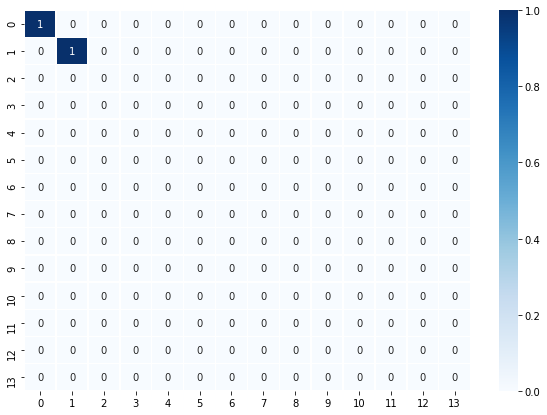

In [13]:

plt.rcParams["figure.figsize"] = (10,7)
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

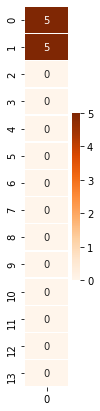

In [14]:

plt.rcParams["figure.figsize"] = (1,7)
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

In [15]:
## Complete the code to implement SLAM
from numpy.linalg import inv
from numpy.linalg import det
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    for k, x in enumerate(data):
        i_robot = k * 2
        measurment = x[0]
        motion = x[1]
        for i in range(len(measurment)):
            i_landmark = 2 * (N + measurment[i][0])
            for j in range(2):
                omega[i_landmark+j][i_landmark+j] += 1.0/measurement_noise
                omega[i_robot+j][i_robot+j]       += 1.0/measurement_noise
                omega[i_robot+j][i_landmark+j]    -= 1.0/measurement_noise     
                omega[i_landmark+j][i_robot+j]    -= 1.0/measurement_noise
                xi[i_landmark+j][0]               += measurment[i][1+j]/measurement_noise
                xi[i_robot+j][0]                  -= measurment[i][1+j]/measurement_noise
        for j in range(4):    
            omega[i_robot+j][i_robot+j] +=   1.0/motion_noise
        for j in range(2):
            omega[i_robot+j][i_robot+j+2] -= 1.0/motion_noise
            omega[i_robot+j+2][i_robot+j] -= 1.0/motion_noise
            xi[i_robot+j][0]              -= motion[j]/motion_noise
            xi[i_robot+j+2][0]            += motion[j]/motion_noise
    mu = np.dot(inv(omega),xi)
    return mu, omega, xi


In [16]:
mu,omega,xi = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

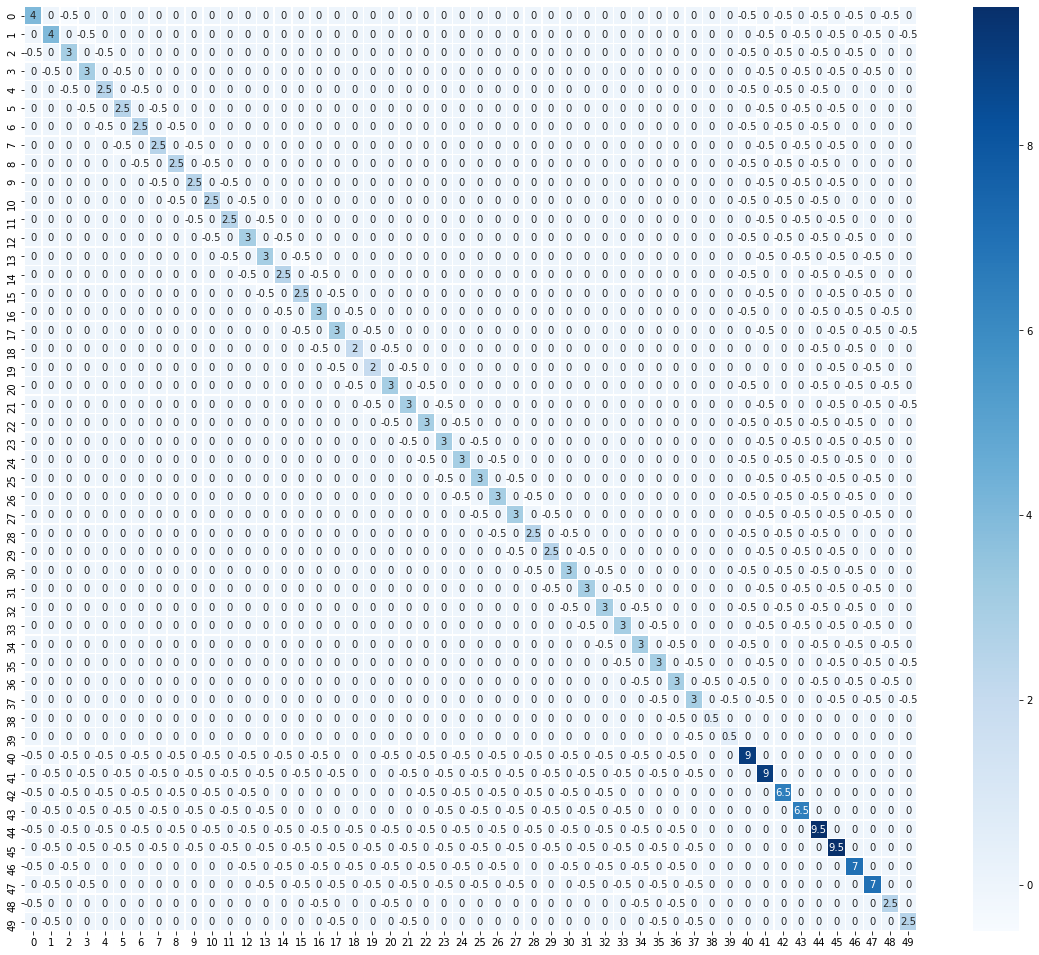

In [17]:

plt.rcParams["figure.figsize"] = (20,17)
sns.heatmap(DataFrame(omega), cmap='Blues', annot=True, linewidths=.5)

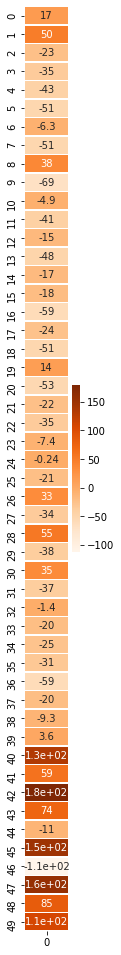

In [18]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,17)
sns.heatmap(DataFrame(xi), cmap='Oranges', annot=True, linewidths=.5)

In [20]:
def get_poses_landmarks(mu, N):
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))
    return poses, landmarks


In [21]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')

In [22]:
mu,_,_ = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)
if(mu is not None):
    
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[50.223, 28.607]
[49.884, 10.191]
[67.924, 5.293]
[85.842, -0.226]
[69.362, 11.585]
[54.204, 22.053]
[39.916, 35.410]
[25.314, 46.811]
[8.423, 57.983]
[28.156, 48.615]
[44.496, 41.505]
[61.548, 34.640]
[78.613, 27.643]
[96.636, 19.667]
[78.935, 26.948]
[60.967, 35.008]
[42.939, 43.080]
[25.607, 49.496]
[6.969, 56.748]


Estimated Landmarks:
[71.093, 36.396]
[92.902, 35.462]
[52.476, 47.149]
[30.184, 61.539]
[68.227, 91.237]


Last pose:  (6.968588328122024, 56.748312665243276)


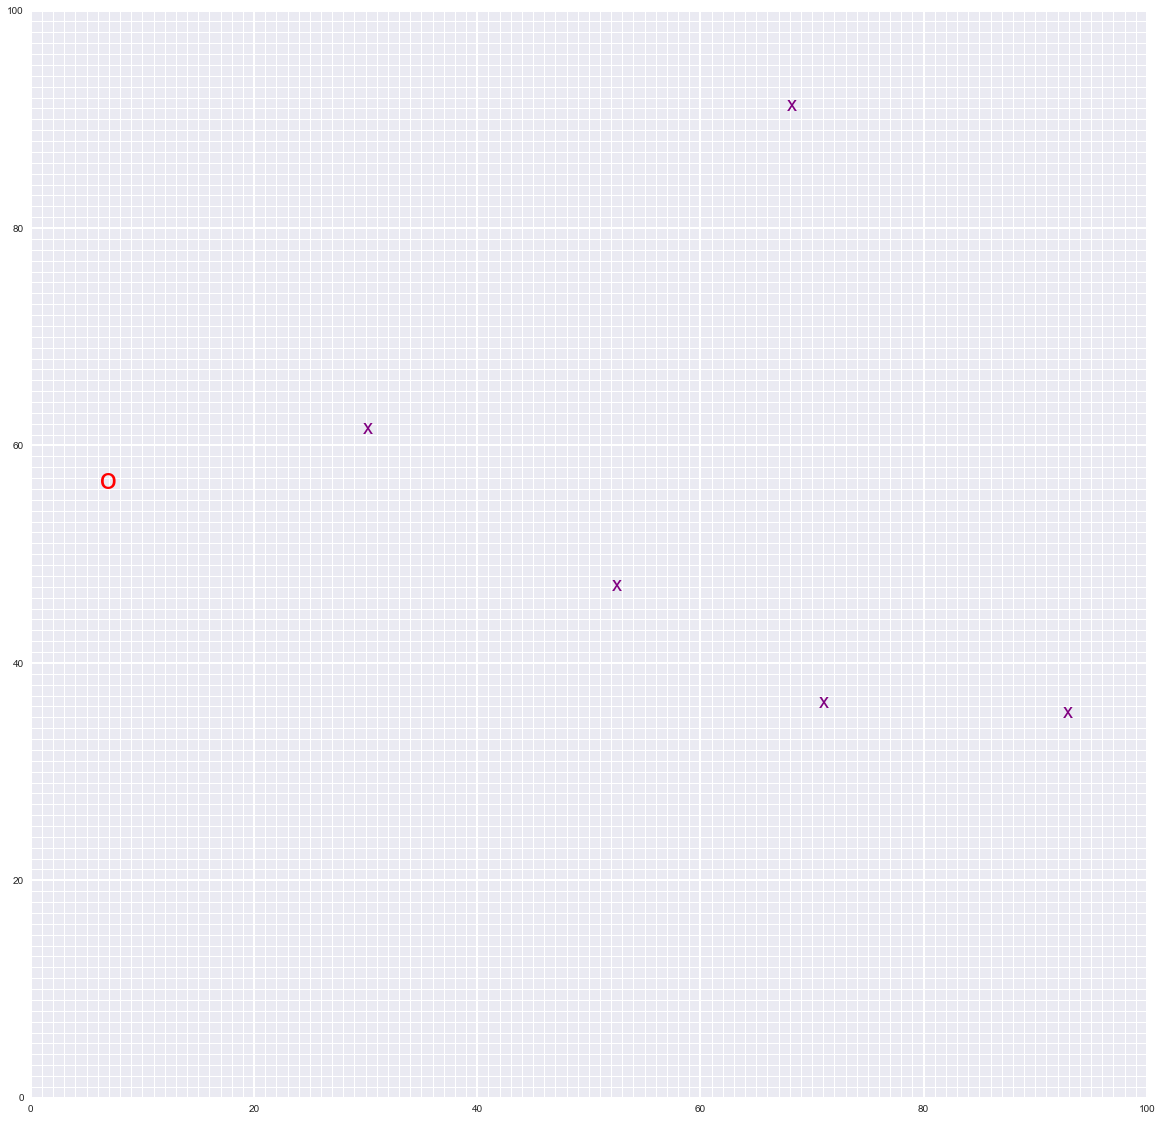

In [23]:
from helpers import display_world
plt.rcParams["figure.figsize"] = (20,20)
if 'poses' in locals():
    print('Last pose: ', poses[-1])

    display_world(int(world_size), poses[-1], landmarks)

In [24]:
test_data1 = [[[[1, 19.457599255548065, 23.8387362100849], [2, -13.195807561967236, 11.708840328458608], [3, -30.0954905279171, 15.387879242505843]], [-12.2607279422326, -15.801093326936487]], [[[2, -0.4659930049620491, 28.088559771215664], [4, -17.866382374890936, -16.384904503932]], [-12.2607279422326, -15.801093326936487]], [[[4, -6.202512900833806, -1.823403210274639]], [-12.2607279422326, -15.801093326936487]], [[[4, 7.412136480918645, 15.388585962142429]], [14.008259661173426, 14.274756084260822]], [[[4, -7.526138813444998, -0.4563942429717849]], [14.008259661173426, 14.274756084260822]], [[[2, -6.299793150150058, 29.047830407717623], [4, -21.93551130411791, -13.21956810989039]], [14.008259661173426, 14.274756084260822]], [[[1, 15.796300959032276, 30.65769689694247], [2, -18.64370821983482, 17.380022987031367]], [14.008259661173426, 14.274756084260822]], [[[1, 0.40311325410337906, 14.169429532679855], [2, -35.069349468466235, 2.4945558982439957]], [14.008259661173426, 14.274756084260822]], [[[1, -16.71340983241936, -2.777000269543834]], [-11.006096015782283, 16.699276945166858]], [[[1, -3.611096830835776, -17.954019226763958]], [-19.693482634035977, 3.488085684573048]], [[[1, 18.398273354362416, -22.705102332550947]], [-19.693482634035977, 3.488085684573048]], [[[2, 2.789312482883833, -39.73720193121324]], [12.849049222879723, -15.326510824972983]], [[[1, 21.26897046581808, -10.121029799040915], [2, -11.917698965880655, -23.17711662602097], [3, -31.81167947898398, -16.7985673023331]], [12.849049222879723, -15.326510824972983]], [[[1, 10.48157743234859, 5.692957082575485], [2, -22.31488473554935, -5.389184118551409], [3, -40.81803984305378, -2.4703329790238118]], [12.849049222879723, -15.326510824972983]], [[[0, 10.591050242096598, -39.2051798967113], [1, -3.5675572049297553, 22.849456408289125], [2, -38.39251065320351, 7.288990306029511]], [12.849049222879723, -15.326510824972983]], [[[0, -3.6225556479370766, -25.58006865235512]], [-7.8874682868419965, -18.379005523261092]], [[[0, 1.9784503557879374, -6.5025974151499]], [-7.8874682868419965, -18.379005523261092]], [[[0, 10.050665232782423, 11.026385307998742]], [-17.82919359778298, 9.062000642947142]], [[[0, 26.526838150174818, -0.22563393232425621], [4, -33.70303936886652, 2.880339841013677]], [-17.82919359778298, 9.062000642947142]]]
#Test 1

mu_1,_,_ = slam(test_data1, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_1, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[37.973, 33.652]
[26.185, 18.155]
[13.745, 2.116]
[28.097, 16.783]
[42.384, 30.902]
[55.831, 44.497]
[70.857, 59.699]
[85.697, 75.543]
[74.011, 92.434]
[53.544, 96.454]
[34.525, 100.080]
[48.623, 83.953]
[60.197, 68.107]
[73.778, 52.935]
[87.132, 38.538]
[80.303, 20.508]
[72.798, 2.945]
[55.245, 13.255]
[37.416, 22.317]


Estimated Landmarks:
[82.956, 13.539]
[70.495, 74.141]
[36.740, 61.281]
[18.698, 66.060]
[20.635, 16.875]


In [25]:
test_data2 = [[[[0, 26.543274387283322, -6.262538160312672], [3, 9.937396825799755, -9.128540360867689]], [18.92765331253674, -6.460955043986683]], [[[0, 7.706544739722961, -3.758467215445748], [1, 17.03954411948937, 31.705489938553438], [3, -11.61731288777497, -6.64964096716416]], [18.92765331253674, -6.460955043986683]], [[[0, -12.35130507136378, 2.585119104239249], [1, -2.563534536165313, 38.22159657838369], [3, -26.961236804740935, -0.4802312626141525]], [-11.167066095509824, 16.592065417497455]], [[[0, 1.4138633151721272, -13.912454837810632], [1, 8.087721200818589, 20.51845934354381], [3, -17.091723454402302, -16.521500551709707], [4, -7.414211721400232, 38.09191602674439]], [-11.167066095509824, 16.592065417497455]], [[[0, 12.886743222179561, -28.703968411636318], [1, 21.660953298391387, 3.4912891084614914], [3, -6.401401414569506, -32.321583037341625], [4, 5.034079343639034, 23.102207946092893]], [-11.167066095509824, 16.592065417497455]], [[[1, 31.126317672358578, -10.036784369535214], [2, -38.70878528420893, 7.4987265861424595], [4, 17.977218575473767, 6.150889254289742]], [-6.595520680493778, -18.88118393939265]], [[[1, 41.82460922922086, 7.847527392202475], [3, 15.711709540417502, -30.34633659912818]], [-6.595520680493778, -18.88118393939265]], [[[0, 40.18454208294434, -6.710999804403755], [3, 23.019508919299156, -10.12110867290604]], [-6.595520680493778, -18.88118393939265]], [[[3, 27.18579315312821, 8.067219022708391]], [-6.595520680493778, -18.88118393939265]], [[], [11.492663265706092, 16.36822198838621]], [[[3, 24.57154567653098, 13.461499960708197]], [11.492663265706092, 16.36822198838621]], [[[0, 31.61945290413707, 0.4272295085799329], [3, 16.97392299158991, -5.274596836133088]], [11.492663265706092, 16.36822198838621]], [[[0, 22.407381798735177, -18.03500068379259], [1, 29.642444125196995, 17.3794951934614], [3, 4.7969752441371645, -21.07505361639969], [4, 14.726069092569372, 32.75999422300078]], [11.492663265706092, 16.36822198838621]], [[[0, 10.705527984670137, -34.589764174299596], [1, 18.58772336795603, -0.20109708164787765], [3, -4.839806195049413, -39.92208742305105], [4, 4.18824810165454, 14.146847823548889]], [11.492663265706092, 16.36822198838621]], [[[1, 5.878492140223764, -19.955352450942357], [4, -7.059505455306587, -0.9740849280550585]], [19.628527845173146, 3.83678180657467]], [[[1, -11.150789592446378, -22.736641053247872], [4, -28.832815721158255, -3.9462962046291388]], [-19.841703647091965, 2.5113335861604362]], [[[1, 8.64427397916182, -20.286336970889053], [4, -5.036917727942285, -6.311739993868336]], [-5.946642674882207, -19.09548221169787]], [[[0, 7.151866679283043, -39.56103232616369], [1, 16.01535401373368, -3.780995345194027], [4, -3.04801331832137, 13.697362774960865]], [-5.946642674882207, -19.09548221169787]], [[[0, 12.872879480504395, -19.707592098123207], [1, 22.236710716903136, 16.331770792606406], [3, -4.841206109583004, -21.24604435851242], [4, 4.27111163223552, 32.25309748614184]], [-5.946642674882207, -19.09548221169787]]] 
mu_2,_,_ = slam(test_data2, 20, 5, 100.0, 2.0, 2.0)
poses, landmarks = get_poses_landmarks(mu_2, 20)
print_all(poses, landmarks)



Estimated Poses:
[50.000, 50.000]
[69.181, 45.665]
[87.743, 39.703]
[76.270, 56.311]
[64.317, 72.176]
[52.257, 88.154]
[44.059, 69.401]
[37.002, 49.918]
[30.924, 30.955]
[23.508, 11.419]
[34.180, 27.133]
[44.155, 43.846]
[54.806, 60.920]
[65.698, 78.546]
[77.468, 95.626]
[96.802, 98.821]
[75.957, 99.971]
[70.200, 81.181]
[64.054, 61.723]
[58.107, 42.628]


Estimated Landmarks:
[76.779, 42.887]
[85.065, 77.438]
[13.548, 95.652]
[59.449, 39.595]
[69.263, 94.240]
